# <center> Predicting Client Gender </center>

### It is necessary to identify the gender of the client based on their transactional historical data. The quality metric is [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), which needs to be maximized.

## File Descriptions
- transactions.csv - historical transactions of bank clients
- gender.csv - gender information for some clients (null for test clients)
- tr_mcc_codes.csv - mcc codes of transactions
- tr_types.csv - types of transactions

## Field Descriptions
### transactions.csv
- client_id - client identifier
- tr_datetime - date and time of the transaction (days are numbered from the start of the data)
- mcc_code - mcc code of the transaction
- tr_type - type of transaction
- amount - transaction amount in conditional units; with a "+" sign — funds credited to the client, "-" — funds debited
- term_id - terminal identifier

### gender.csv
- client_id - client identifier
- gender - client gender (empty values for test clients)

### tr_mcc_codes.csv
- mcc_code - mcc code of the transaction
- mcc_description - description of the mcc code

### tr_types.csv
- tr_type - type of transaction
- tr_description - description of the transaction type

## Tasks:
- Develop a binary classification model to determine the client's gender. There are no restrictions on the model - it can be anything from KNN to transformers. The main goal is to achieve an ROC AUC above 77.5% on the hold-out test set.
- Interpret the model results: the importance of the variables included in it, demonstrating on several examples why the corresponding prediction was made. This will help understand which gender corresponds to which target (0/1). Again, there is complete freedom of choice of approaches! Useful keywords: gain, permutation importance, SHAP.
- Convert the results into a report without code (ideally - directly into [html](https://stackoverflow.com/questions/49907455/hide-code-when-exporting-jupyter-notebook-to-html))

#### P.S. Don't forget about [PEP8](https://www.python.org/dev/peps/pep-0008/)!

In [53]:
%load_ext autoreload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.ensemble import HistGradientBoostingClassifier, \
                             GradientBoostingClassifier, \
                             RandomForestClassifier \
                            #  BaggingClassifier,\
                            #  StackingClassifier, \
                            #  VotingClassifier
# from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
# from sklearn.linear_model import LogisticRegressionCV
# from lightgbm import LGBMClassifier
# from sklearn.feature_extraction.text import TfidfVectorizer
from operator import itemgetter
import warnings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
warnings.filterwarnings(action = 'ignore')

# Объединение датасетов

In [55]:
tr_mcc_codes = pd.read_csv("data/mcc_codes.csv", sep=";", index_col="mcc_code")
tr_types = pd.read_csv("data/trans_types.csv", sep=";", index_col="trans_type")

transactions = pd.read_csv("data/transactions.csv", index_col="client_id")
test_gender = pd.read_csv("data/test.csv", index_col="client_id")
train_gender = pd.read_csv("data/train.csv", index_col="client_id")
gender = pd.concat([train_gender, test_gender]).drop('Unnamed: 0', axis=1)

del test_gender, train_gender

In [56]:
tr_mcc_codes.head(3)

,mcc_description
mcc_code,
742,Ветеринарные услуги
1711,"Генеральные подрядчики по вентиляции, теплосна..."
1731,Подрядчики по электричеству


In [57]:
tr_types.head(3)

,trans_description
trans_type,
3200,Плата за предоставление услуг посредством моби...
3210,Плата за предоставление отчета по счету карты ...
3800,Плата за обслуживание банковской карты (за пер...


In [58]:
transactions.head(3)

,trans_time,mcc_code,trans_type,amount,term_id,trans_city
client_id,,,,,,
d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver
81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,6011,7010,7954.51,442207,Kazan
fc0c7c937f139bd6d1c5b5d0a0023dd3,150 16:03:59,6011,2010,-12293.56,NaN,Khabarovsk


In [59]:
gender.head(3)

,gender
client_id,
c5f18a1d1d83fda62e51e6ae1d7b8911,1.0
4b6861803556de90249e13d7cf66f0a9,0.0
7d3f908e1cd1e3624a1445df5e04c4fa,1.0


In [60]:
df = transactions
df = df.join(gender)
df = pd.merge(df, tr_types, left_on="trans_type", right_index=True)
df = pd.merge(df, tr_mcc_codes, left_on="mcc_code", right_index=True)
del transactions, tr_types, tr_mcc_codes, gender
df

,trans_time,mcc_code,trans_type,amount,term_id,trans_city,gender,trans_description,mcc_description
client_id,,,,,,,,,
d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver,0.0,Списание с карты на карту по операции <перевод...,Денежные переводы
81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,6011,7010,7954.51,442207,Kazan,0.0,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...
fc0c7c937f139bd6d1c5b5d0a0023dd3,150 16:03:59,6011,2010,-12293.56,NaN,Khabarovsk,NaN,Выдача наличных в АТМ Сбербанк России,Финансовые институты — снятие наличности автом...
3495487d5beaa5caaa0682fddc38379a,373 11:54:12,6010,7070,49.52,888987,Kaliningrad,0.0,Перевод на карту (с карты) через Мобильный бан...,Финансовые институты — снятие наличности вручную
07e279042b1da23710fa2f65034d30b9,340 13:11:45,6010,7070,45.29,888918,Saint Petersburg,0.0,Перевод на карту (с карты) через Мобильный бан...,Финансовые институты — снятие наличности вручную
...,...,...,...,...,...,...,...,...,...
e91858185ae43cf3970220748893a01b,328 13:45:38,6010,7070,227.40,888907,Penza,0.0,Перевод на карту (с карты) через Мобильный бан...,Финансовые институты — снятие наличности вручную
429b6c8255f13bdb506fdbd6e342ccb1,10 19:22:35,4814,1030,-1084.44,NaN,Khabarovsk,0.0,Оплата услуги. Банкоматы СБ РФ,"Звонки с использованием телефонов, считывающих..."
9443b6a0d948cf368d8d72eb295bdfdf,167 23:59:15,5411,1110,-569.20,NaN,Tver,0.0,Покупка. POS ТУ Россия,"Бакалейные магазины, супермаркеты"


In [61]:
df = df.loc[df['gender'].notna()]

In [62]:
df.head(3)

,trans_time,mcc_code,trans_type,amount,term_id,trans_city,gender,trans_description,mcc_description
client_id,,,,,,,,,
d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver,0.0,Списание с карты на карту по операции <перевод...,Денежные переводы
81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,6011,7010,7954.51,442207,Kazan,0.0,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...
3495487d5beaa5caaa0682fddc38379a,373 11:54:12,6010,7070,49.52,888987,Kaliningrad,0.0,Перевод на карту (с карты) через Мобильный бан...,Финансовые институты — снятие наличности вручную


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3237373 entries, d1bbbc9a0e0410d3cf12a3d2f44f3450 to 8d69e4ecae4b509d528b9a0168f749d0
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   trans_time         object 
 1   mcc_code           int64  
 2   trans_type         int64  
 3   amount             float64
 4   term_id            object 
 5   trans_city         object 
 6   gender             float64
 7   trans_description  object 
 8   mcc_description    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 247.0+ MB


In [64]:
def missing_features(data, column_set):
    incomplete_features = {feature: data.shape[0]-sum(data[feature].value_counts())
                                   for feature in column_set
                                   if not sum(data[feature].value_counts()) == data.shape[0]}
    incomplete_features_sorted = sorted(incomplete_features, key=lambda feature: incomplete_features[feature], reverse=True)
    incompleteness = [round((incomplete_features[feature]/data.shape[0])*100, 2) for feature in incomplete_features_sorted]
    
    for feature, percentage in zip(incomplete_features_sorted, incompleteness):
        print(f'{feature} {incomplete_features[feature]} ({percentage}%)')
missing_features(df, df.columns)

term_id 1310923 (40.49%)


<Axes: xlabel='amount', ylabel='Density'>

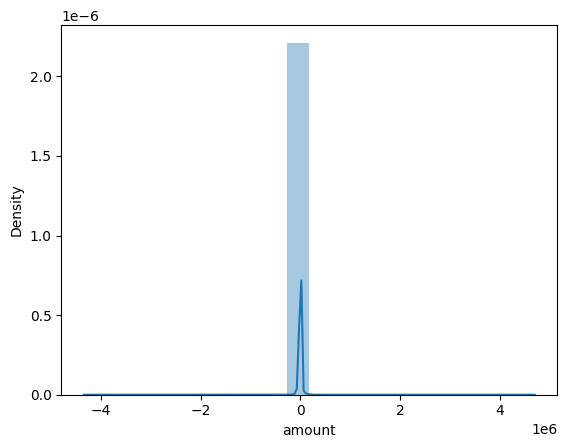

In [65]:
sns.distplot(df['amount'], bins=20)

# Corelation Matrix

In [66]:
df.columns

Index(['trans_time', 'mcc_code', 'trans_type', 'amount', 'term_id',
       'trans_city', 'gender', 'trans_description', 'mcc_description'],
      dtype='object')

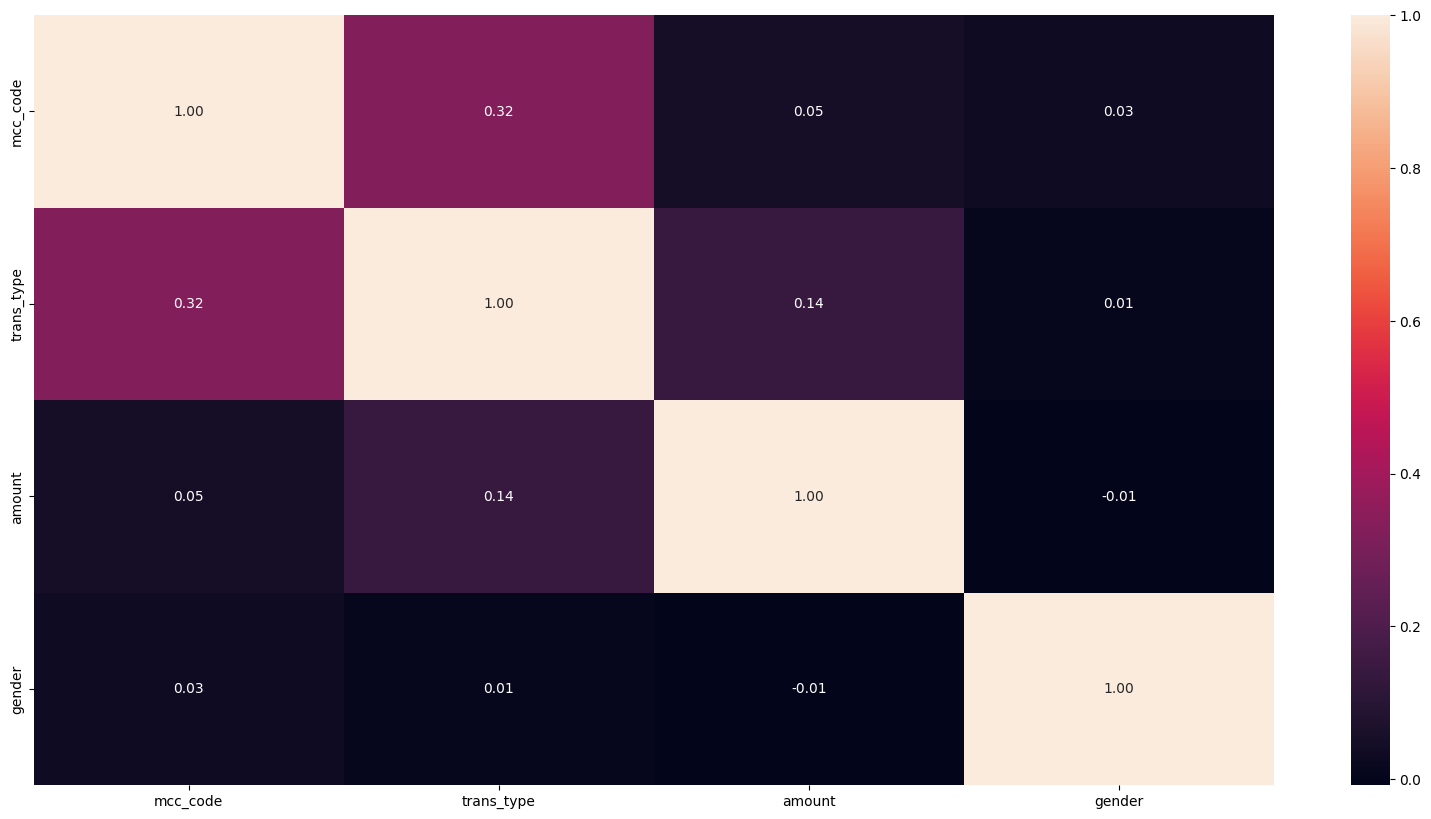

In [67]:
plt.figure(figsize=(20, 10))
sns.heatmap(
    df.select_dtypes(include=[np.number]).corr(),  # Select only numerical columns
    annot=True,
    fmt='.2f',
    # cmap='coolwarm'
)
plt.show()

# Feature Engineering

In [68]:
df

,trans_time,mcc_code,trans_type,amount,term_id,trans_city,gender,trans_description,mcc_description
client_id,,,,,,,,,
d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver,0.0,Списание с карты на карту по операции <перевод...,Денежные переводы
81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,6011,7010,7954.51,442207,Kazan,0.0,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...
3495487d5beaa5caaa0682fddc38379a,373 11:54:12,6010,7070,49.52,888987,Kaliningrad,0.0,Перевод на карту (с карты) через Мобильный бан...,Финансовые институты — снятие наличности вручную
07e279042b1da23710fa2f65034d30b9,340 13:11:45,6010,7070,45.29,888918,Saint Petersburg,0.0,Перевод на карту (с карты) через Мобильный бан...,Финансовые институты — снятие наличности вручную
ec41f598a99167b68cb8e232f524017f,117 11:28:27,6011,2010,-28924.22,NaN,Vladivostok,0.0,Выдача наличных в АТМ Сбербанк России,Финансовые институты — снятие наличности автом...
...,...,...,...,...,...,...,...,...,...
e91858185ae43cf3970220748893a01b,328 13:45:38,6010,7070,227.40,888907,Penza,0.0,Перевод на карту (с карты) через Мобильный бан...,Финансовые институты — снятие наличности вручную
429b6c8255f13bdb506fdbd6e342ccb1,10 19:22:35,4814,1030,-1084.44,NaN,Khabarovsk,0.0,Оплата услуги. Банкоматы СБ РФ,"Звонки с использованием телефонов, считывающих..."
9443b6a0d948cf368d8d72eb295bdfdf,167 23:59:15,5411,1110,-569.20,NaN,Tver,0.0,Покупка. POS ТУ Россия,"Бакалейные магазины, супермаркеты"


In [69]:
df.columns.tolist()

['trans_time',
 'mcc_code',
 'trans_type',
 'amount',
 'term_id',
 'trans_city',
 'gender',
 'trans_description',
 'mcc_description']

In [70]:
df['earned'] = [0 if i <0 else 1 for i in df['amount']]

In [71]:
df['day'] = pd.DataFrame(df["trans_time"].str.split(' ', expand = True)[0]).astype("int64").fillna(0)
df['time'] = pd.DataFrame(df["trans_time"].str.split(' ', expand = True)[1].str.split(':', expand = True)[0]).astype("int64")

In [72]:
df['total'] = df.groupby(['client_id'])["amount"].sum().fillna(0)
df['total_spent'] = df.loc[df['earned'] == 0].groupby(['client_id'])["amount"].sum().fillna(0)
df['total_earned'] = df.loc[df['earned'] == 1].groupby(['client_id'])["amount"].sum().fillna(0)

In [73]:
df["avg_amount_per_day"] = df.groupby(['client_id','day'])["amount"].transform('mean').fillna(0)
df["var_amount_per_day"] = df.groupby(['client_id','day'])["amount"].transform('std').fillna(0)

In [74]:
df['avg_sum_per_transaction'] = df.groupby(['client_id'])['amount'].mean().fillna(0)
df['avg_sum_spent_per_transaction'] = df.loc[df['earned'] == 0].groupby(['client_id'])['amount'].mean().fillna(0)
df['avg_sum_earned_per_transaction'] = df.loc[df['earned'] == 1].groupby(['client_id'])['amount'].mean().fillna(0)

In [75]:
df['var_sum_per_trans'] = df.groupby(['client_id'])['amount'].std().fillna(0)
df['var_sum_spent_per_trans'] = df.loc[df['earned'] == 0].groupby(['client_id'])['amount'].std().fillna(0)
df['var_sum_earned_per_trans'] = df.loc[df['earned'] == 1].groupby(['client_id'])['amount'].std().fillna(0)

In [76]:
df['transactions_per_day'] = df.groupby([df.index, 'day'])["day"].transform("count").fillna(0)
df['transactions_per_day_spent'] = df.groupby(['client_id'])["day"].transform(lambda x: x[x < 0].count()).fillna(0)
df['transactions_per_day_earned'] = df.groupby(['client_id'])["day"].transform(lambda x: x[x > 0].count()).fillna(0)

In [77]:
df["var_amount_per_day"] = df.groupby(['client_id','day'])['amount'].transform('std').fillna(0)

In [78]:
df['sum_per_day'] = df.groupby(['client_id', 'day'])['amount'].transform('sum').fillna(0)
df['sum_per_day_spent'] = df.loc[df['earned'] == 0].groupby(['client_id', 'day'])['amount'].sum().fillna(0)
df['sum_per_day_earned'] = df.loc[df['earned'] == 1].groupby(['client_id', 'day'])['amount'].sum().fillna(0)

In [79]:
df['terminal_unique'] = df.groupby(['client_id','term_id'])['term_id'].transform('count').fillna(0)

In [80]:
df["var_time_transaction"] = df.groupby(['client_id'])['time'].transform('std')

In [81]:

df['tr_unique_count'] = df.groupby(['client_id',"trans_type"])["trans_type"].transform('count').fillna(0)
df['tr_unique_sum'] = df.groupby(['client_id',"trans_type"])["trans_type"].transform('sum').fillna(0)
df['tr_unique_std'] = df.groupby(['client_id',"trans_type"])["trans_type"].transform('std').fillna(0)

In [82]:
df['mcc_unique_count'] = df.groupby(['client_id','mcc_code'])['mcc_code'].transform('count').fillna(0)
df['mcc_unique_sum'] = df.groupby(['client_id','mcc_code'])['mcc_code'].transform('sum').fillna(0)
df['mcc_unique_std'] = df.groupby(['client_id','mcc_code'])['mcc_code'].transform('std').fillna(0)

In [83]:
df['tr_unique_count'] = df.groupby(['client_id','trans_type'])['trans_type'].transform('count').fillna(0)

In [84]:
df["total_amount_spend_to_earn"] = np.divide(df["total_spent"].abs(), df["total_earned"].abs())
df["total_amount_spend_to_earn"].replace(np.inf, 1000, inplace = True)

In [85]:
df = pd.DataFrame(pd.get_dummies(data = df, columns = ['trans_type', 'mcc_code']))

# Grouping by client_id

In [86]:
df

,trans_time,amount,term_id,trans_city,gender,trans_description,mcc_description,earned,day,time,...,mcc_code_8299,mcc_code_8398,mcc_code_8641,mcc_code_8699,mcc_code_8999,mcc_code_9211,mcc_code_9222,mcc_code_9311,mcc_code_9399,mcc_code_9402
client_id,,,,,,,,,,,,,,,,,,,,,
d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,-1808.56,NaN,Tver,0.0,Списание с карты на карту по операции <перевод...,Денежные переводы,0,35,8,...,False,False,False,False,False,False,False,False,False,False
81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,7954.51,442207,Kazan,0.0,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...,1,351,13,...,False,False,False,False,False,False,False,False,False,False
3495487d5beaa5caaa0682fddc38379a,373 11:54:12,49.52,888987,Kaliningrad,0.0,Перевод на карту (с карты) через Мобильный бан...,Финансовые институты — снятие наличности вручную,1,373,11,...,False,False,False,False,False,False,False,False,False,False
07e279042b1da23710fa2f65034d30b9,340 13:11:45,45.29,888918,Saint Petersburg,0.0,Перевод на карту (с карты) через Мобильный бан...,Финансовые институты — снятие наличности вручную,1,340,13,...,False,False,False,False,False,False,False,False,False,False
ec41f598a99167b68cb8e232f524017f,117 11:28:27,-28924.22,NaN,Vladivostok,0.0,Выдача наличных в АТМ Сбербанк России,Финансовые институты — снятие наличности автом...,0,117,11,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e91858185ae43cf3970220748893a01b,328 13:45:38,227.40,888907,Penza,0.0,Перевод на карту (с карты) через Мобильный бан...,Финансовые институты — снятие наличности вручную,1,328,13,...,False,False,False,False,False,False,False,False,False,False
429b6c8255f13bdb506fdbd6e342ccb1,10 19:22:35,-1084.44,NaN,Khabarovsk,0.0,Оплата услуги. Банкоматы СБ РФ,"Звонки с использованием телефонов, считывающих...",0,10,19,...,False,False,False,False,False,False,False,False,False,False
9443b6a0d948cf368d8d72eb295bdfdf,167 23:59:15,-569.20,NaN,Tver,0.0,Покупка. POS ТУ Россия,"Бакалейные магазины, супермаркеты",0,167,23,...,False,False,False,False,False,False,False,False,False,False


In [87]:
numeric_cols = df.select_dtypes(include=[np.number, np.bool_]).columns
df_customers = df.groupby(['client_id'])[numeric_cols].max()

In [88]:
y = df_customers['gender']
X = df_customers.drop(['gender', 'amount', 'earned'], axis = 1)

In [89]:
X['total_earned'] = X['total_earned'].fillna(0)
X['avg_sum_earned_per_transaction'] = X['avg_sum_earned_per_transaction'].fillna(0)
X['total_spent'] = X['total_spent'].fillna(0)
X['avg_sum_spent_per_transaction'] = X['avg_sum_spent_per_transaction'].fillna(0)
X['var_sum_earned_per_trans'] = X['var_sum_earned_per_trans'].fillna(0)
X['var_sum_spent_per_trans'] = X['var_sum_spent_per_trans'].fillna(0)
X['var_time_transaction'] = X['var_time_transaction'].fillna(0)
X['total_amount_spend_to_earn'] = X['total_amount_spend_to_earn'].fillna(0)
# X['amount'] =  X['amount'].fillna(0)

In [90]:
missing_features(X, X.columns)

sum_per_day_spent 7560 (100.0%)
sum_per_day_earned 7560 (100.0%)


In [91]:
# drop the columns with missing values
X = X.drop(['sum_per_day_spent', 'sum_per_day_earned'], axis = 1)
missing_features(X, X.columns)

# Catboost

In [92]:
cb = CatBoostClassifier(depth= 4, iterations= 25, l2_leaf_reg= 0, learning_rate= 0.5)

In [93]:
cb.fit(X, y)

0:	learn: 0.6088873	total: 5.06ms	remaining: 121ms
1:	learn: 0.5651690	total: 7.93ms	remaining: 91.2ms
2:	learn: 0.5448952	total: 11ms	remaining: 81ms
3:	learn: 0.5286176	total: 14.6ms	remaining: 76.5ms
4:	learn: 0.5186193	total: 17.5ms	remaining: 70.1ms
5:	learn: 0.5082568	total: 20.4ms	remaining: 64.4ms
6:	learn: 0.5024343	total: 24ms	remaining: 61.6ms
7:	learn: 0.4973212	total: 26.7ms	remaining: 56.6ms
8:	learn: 0.4921810	total: 29.1ms	remaining: 51.7ms
9:	learn: 0.4863886	total: 31.3ms	remaining: 47ms
10:	learn: 0.4836113	total: 33.5ms	remaining: 42.6ms
11:	learn: 0.4794957	total: 36.4ms	remaining: 39.5ms
12:	learn: 0.4764210	total: 39.2ms	remaining: 36.2ms
13:	learn: 0.4724502	total: 41.4ms	remaining: 32.6ms
14:	learn: 0.4697401	total: 43.8ms	remaining: 29.2ms
15:	learn: 0.4667888	total: 46.3ms	remaining: 26ms
16:	learn: 0.4640025	total: 48.6ms	remaining: 22.9ms
17:	learn: 0.4612791	total: 51ms	remaining: 19.8ms
18:	learn: 0.4588061	total: 53.3ms	remaining: 16.8ms
19:	learn: 0.455

In [94]:
cv_split = KFold(n_splits = 4)

In [95]:
cv_results = cross_validate(cb, X, y, scoring='roc_auc', cv=cv_split, return_train_score=True)

0:	learn: 0.6070579	total: 4.22ms	remaining: 101ms
1:	learn: 0.5625855	total: 6.28ms	remaining: 72.2ms
2:	learn: 0.5434949	total: 8.24ms	remaining: 60.5ms
3:	learn: 0.5309186	total: 11.4ms	remaining: 59.6ms
4:	learn: 0.5200495	total: 13.4ms	remaining: 53.7ms
5:	learn: 0.5102590	total: 15.5ms	remaining: 49.1ms
6:	learn: 0.5050187	total: 17.6ms	remaining: 45.1ms
7:	learn: 0.4973843	total: 19.5ms	remaining: 41.5ms
8:	learn: 0.4920119	total: 21.7ms	remaining: 38.6ms
9:	learn: 0.4883333	total: 24ms	remaining: 36ms
10:	learn: 0.4824356	total: 26.1ms	remaining: 33.2ms
11:	learn: 0.4772078	total: 28.4ms	remaining: 30.8ms
12:	learn: 0.4744371	total: 30.5ms	remaining: 28.1ms
13:	learn: 0.4703884	total: 32.8ms	remaining: 25.8ms
14:	learn: 0.4653196	total: 34.9ms	remaining: 23.3ms
15:	learn: 0.4607757	total: 36.9ms	remaining: 20.8ms
16:	learn: 0.4581277	total: 39ms	remaining: 18.3ms
17:	learn: 0.4554511	total: 41.3ms	remaining: 16.1ms
18:	learn: 0.4525035	total: 43.5ms	remaining: 13.7ms
19:	learn:

In [96]:
cv_results

{'fit_time': array([0.07458711, 0.07164717, 0.07024884, 0.07219625]),
 'score_time': array([0.00770807, 0.00687504, 0.00667977, 0.00659776]),
 'test_score': array([0.84256833, 0.84267361, 0.83362673, 0.84181719]),
 'train_score': array([0.8841668 , 0.88611471, 0.88528546, 0.88673717])}

In [97]:
cv_results['test_score'].mean()

0.840171463632342

# Grid Search

In [98]:
# params = {
#     'iterations': [5,10,15,20,25,30],
#     'learning_rate': [0.5, 0.1, 0.05, 0.01],
#     'l2_leaf_reg': [0.5, 0.1, 0.05, 0.01],
#     'depth': [None,1,2,3,4,5],
#     'l2_leaf_reg': [0,0.1,0.01]
# }

# cb_cv = GridSearchCV(cb, param_grid=params, scoring='roc_auc', cv=5)

In [99]:
# cb_cv.fit(X, y)

In [100]:
# cb_cv.best_params_

# Feature importance

In [101]:
feature_importance = sorted(list(zip(X.columns,cb.feature_importances_.tolist())), key=itemgetter(1))
feature_importance

[('time', 0.0),
 ('var_amount_per_day', 0.0),
 ('transactions_per_day', 0.0),
 ('transactions_per_day_spent', 0.0),
 ('tr_unique_count', 0.0),
 ('tr_unique_sum', 0.0),
 ('tr_unique_std', 0.0),
 ('mcc_unique_count', 0.0),
 ('mcc_unique_std', 0.0),
 ('trans_type_1000', 0.0),
 ('trans_type_1010', 0.0),
 ('trans_type_1030', 0.0),
 ('trans_type_1110', 0.0),
 ('trans_type_1200', 0.0),
 ('trans_type_1210', 0.0),
 ('trans_type_1310', 0.0),
 ('trans_type_1510', 0.0),
 ('trans_type_2010', 0.0),
 ('trans_type_2011', 0.0),
 ('trans_type_2020', 0.0),
 ('trans_type_2021', 0.0),
 ('trans_type_2100', 0.0),
 ('trans_type_2110', 0.0),
 ('trans_type_2200', 0.0),
 ('trans_type_2210', 0.0),
 ('trans_type_2320', 0.0),
 ('trans_type_2330', 0.0),
 ('trans_type_2331', 0.0),
 ('trans_type_2340', 0.0),
 ('trans_type_2341', 0.0),
 ('trans_type_2371', 0.0),
 ('trans_type_4010', 0.0),
 ('trans_type_4011', 0.0),
 ('trans_type_4021', 0.0),
 ('trans_type_4031', 0.0),
 ('trans_type_4035', 0.0),
 ('trans_type_4041', 0.0

In [102]:
# remove all features with importance <= 0.01
important_features = [feature for feature, importance in feature_importance if importance > 0.01]
X = X[important_features]

In [103]:
# params = {
#     'iterations': [5,10,15,20,25,30],
#     'learning_rate': [0.5, 0.1, 0.05, 0.01],
#     'l2_leaf_reg': [0.5, 0.1, 0.05, 0.01],
#     'depth': [None,1,2,3,4,5],
#     'l2_leaf_reg': [0,0.1,0.01]
# }

# cb_cv = GridSearchCV(cb, param_grid=params, scoring='roc_auc', cv=5)

In [104]:
# cb_cv.fit(X, y)

In [105]:
# cb_cv.best_params_

In [106]:
# use best parameters
cb = CatBoostClassifier(depth= 4, iterations= 30, l2_leaf_reg= 0.1, learning_rate= 0.5)

In [107]:
cv_results = cross_validate(cb, X, y, scoring='roc_auc', cv=cv_split, return_train_score=True)

0:	learn: 0.6091104	total: 1.28ms	remaining: 37.2ms
1:	learn: 0.5736331	total: 2.81ms	remaining: 39.4ms
2:	learn: 0.5514127	total: 4.37ms	remaining: 39.3ms
3:	learn: 0.5363634	total: 5.66ms	remaining: 36.8ms
4:	learn: 0.5234070	total: 7.06ms	remaining: 35.3ms
5:	learn: 0.5125624	total: 8.35ms	remaining: 33.4ms
6:	learn: 0.5059650	total: 9.68ms	remaining: 31.8ms
7:	learn: 0.5021888	total: 11ms	remaining: 30.2ms
8:	learn: 0.4963361	total: 12.7ms	remaining: 29.5ms
9:	learn: 0.4908059	total: 14.1ms	remaining: 28.2ms
10:	learn: 0.4845095	total: 15.5ms	remaining: 26.8ms
11:	learn: 0.4809031	total: 16.9ms	remaining: 25.3ms
12:	learn: 0.4777873	total: 18.5ms	remaining: 24.2ms
13:	learn: 0.4741133	total: 19.8ms	remaining: 22.6ms
14:	learn: 0.4705449	total: 21.2ms	remaining: 21.2ms
15:	learn: 0.4666503	total: 22.5ms	remaining: 19.7ms
16:	learn: 0.4630552	total: 23.8ms	remaining: 18.2ms
17:	learn: 0.4600403	total: 25.4ms	remaining: 16.9ms
18:	learn: 0.4562847	total: 26.9ms	remaining: 15.6ms
19:	l

In [108]:
cv_results

{'fit_time': array([0.05416393, 0.05241323, 0.05259705, 0.05024004]),
 'score_time': array([0.00280595, 0.00268483, 0.00264287, 0.00287199]),
 'test_score': array([0.84246976, 0.8387333 , 0.84902274, 0.84163397]),
 'train_score': array([0.88953708, 0.89542985, 0.89180808, 0.89116679])}

In [109]:
cv_results['test_score'].mean()

0.8429649408679287

# Random Forest

In [110]:
mm_scaler = MinMaxScaler()
scaled_X = mm_scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns = X.columns)

In [111]:
rf = RandomForestClassifier()

In [112]:
# params = {
#     'n_estimators': [5,10,15,20,25,30,100],
# #     'learning_rate': [0.5, 0.1, 0.05, 0.01],
# #     'l2_leaf_reg': [0.5, 0.1, 0.05, 0.01],
#     'max_depth': [None,1,2,3,4,5],
#     'min_samples_split': [2,3,5,10],
#     'min_samples_leaf': [1,3,5,10],
# #     'l2_leaf_reg': [0,0.1,0.01]
# #     n_estimators=100,
# #     *,
# #     criterion='gini',
# }

# rf_cv = GridSearchCV(rf, param_grid=params, scoring='roc_auc', cv=5)

In [113]:
# rf_cv.fit(scaled_X, y)

In [114]:
# rf_cv.best_params_

In [115]:
# use best parameters
rf = RandomForestClassifier(max_depth= None, min_samples_leaf= 5, min_samples_split= 10, n_estimators= 100)

In [116]:
rf_results = cross_validate(rf, X, y, scoring='roc_auc', cv=cv_split, return_train_score=True)

In [117]:
rf_results

{'fit_time': array([0.66046214, 0.67192507, 0.64102006, 0.63527298]),
 'score_time': array([0.01722908, 0.01693106, 0.01677799, 0.01695108]),
 'test_score': array([0.8228968 , 0.82620064, 0.82574311, 0.82761491]),
 'train_score': array([0.98632146, 0.98528191, 0.98487667, 0.98546825])}

In [118]:
rf_results['test_score'].mean()

0.8256138653476028